# Plotting overturning circulation in ACCESS-OM3

This notebook uses the initial spinup simulation of ACCESS-OM3.

In [1]:
import intake
from dask.distributed import Client
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import cmocean as cm

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 24
Total threads: 24,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40849,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35975,Total threads: 1
Dashboard: /proxy/44745/status,Memory: 3.96 GiB
Nanny: tcp://127.0.0.1:36993,


## Load data from ESM datastore

In [3]:
datastore = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"
cat = intake.open_esm_datastore( datastore,
    columns_with_iterables=["variable"] # This is important
)

In [4]:
ds_vmo = cat.search(variable="vmo").to_dask()
ds_vhGM = cat.search(variable="vhGM").to_dask()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTi

## 10-year mean overturning streamfunction

In [5]:
vmo = ds_vmo["vmo"]+ds_vhGM["vhGM"]
psi = vmo.sel(time=slice("1918-01-01","1927-12-31")).mean('time').sum('xh').cumsum('rho2_l')/1025/1e6
psi.load()

<xarray.DataArray (rho2_l: 76, yq: 1142)> Size: 347kB
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.8024955e-03,  1.8427816e-03,  9.7560970e-10],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.7200821e-02,  3.7500884e-02, -3.0243900e-08],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.1173980e-02,  3.2825619e-02, -3.2195121e-08],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.6094591e-02, -1.5249714e-02, -6.3292681e-08],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.5564168e-02, -1.5561293e-02, -7.1097560e-08],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.9529599e-03,  8.8957953e-04, -7.1097560e-08]], dtype=float32)
Coordinates:
  * yq       (yq) float64 9kB -80.9 -80.84 -80.77 -80.71 ... 89.79 89.9 90.0
  * rho2_l   (rho2_l) float64 608B 1.01e+03 1.027e+03 ... 1.037e+03 1.039e+03

Text(0.5, 1.0, 'Overturning in ACCESS-OM3')

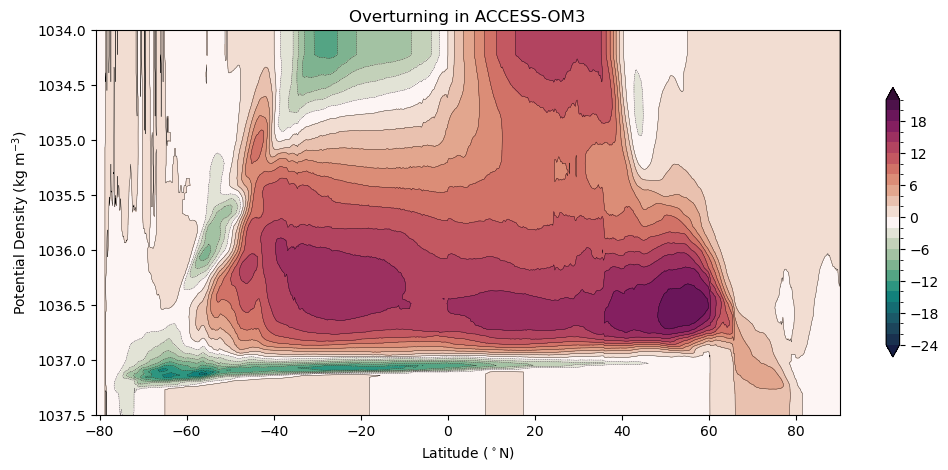

In [6]:
plt.figure(figsize=(12, 5)) 
levels = range(-24,24,2)
psi.plot.contourf(levels=levels, cmap=cm.cm.curl,extend='both',cbar_kwargs={'shrink': 0.7})
psi.plot.contour(levels=levels, colors='k', linewidths=0.25)
plt.gca().invert_yaxis()
plt.ylim((1037.5, 1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.title('Overturning in ACCESS-OM3')

## Timeseries of overturning at key latitudes

In [7]:
psi_time = vmo.sum('xh').cumsum('rho2_l')/1025/1e6
psi_30S = psi_time.sel(yq=-30,method='nearest').sel(rho2_l=slice(1035,1038)).max(dim='rho2_l').load()
psi_26N = psi_time.sel(yq=26,method='nearest').sel(rho2_l=slice(1035,1038)).max(dim='rho2_l').load()
psi_55N = psi_time.sel(yq=5,method='nearest').sel(rho2_l=slice(1035,1038)).max(dim='rho2_l').load()
psi_abyss = -psi_time.sel(yq=-60,method='nearest').sel(rho2_l=slice(1035,1038)).min(dim='rho2_l').load()


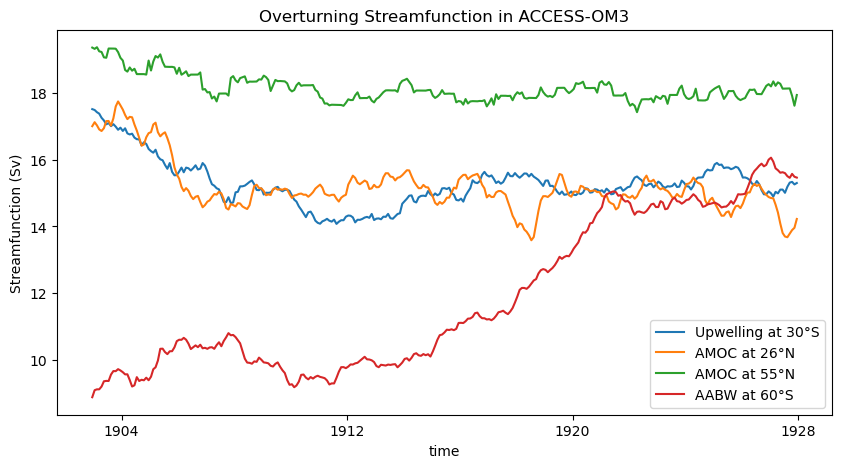

In [8]:
plt.figure(figsize=(10, 5)) 

psi_30S.rolling(time=12).mean().plot(label='Upwelling at 30°S')
psi_26N.rolling(time=12).mean().plot(label='AMOC at 26°N')
psi_55N.rolling(time=12).mean().plot(label='AMOC at 55°N')
psi_abyss.rolling(time=12).mean().plot(label='AABW at 60°S')

plt.ylabel('Streamfunction (Sv)')
plt.title('Overturning Streamfunction in ACCESS-OM3')
plt.legend()